<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cartesian_explorer import Explorer

%load_ext autoreload
%autoreload 2

In [2]:
ex = Explorer()

In [3]:
@ex.add_function(provides=('flavour', 'colour'), requires=('label', 'delimeter'))
def unpack_label(label, delimeter):
    flavour, colour = label.split(delimeter)
    return flavour, colour

@ex.add_function(provides='cost', requires=('flavour', 'colour', 'date'))
def get_cost_history(flavour, colour, date):
    base_fare = 1
    volatility = 1
    trend = 0
    if flavour=='almond':
        base_fare *= 2
        trend += 1
    else:
        volatility += 2
        
    if colour=='red':
        trend -= 1
        base_fare += 3
        volatility += 1.4
        
    return np.random.laplace(loc=base_fare, scale=volatility) + trend*date


param_space {'varnames': [['cost']], 'date': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), 'label': ['almond_red', 'almond_blue', 'orange_orange', 'orange_red'], 'delimeter': ('_',)}


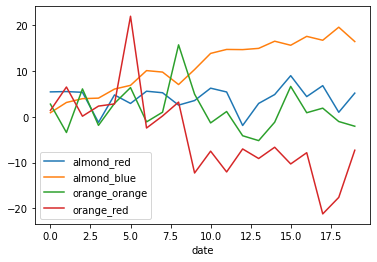

In [4]:
ex.plot_variables2d('cost',
                    date=np.arange(20),
                    label=['almond_red', 'almond_blue', 'orange_orange', 'orange_red'],
                    delimeter='_')